In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Cargar el archivo Parquet
df = pd.read_parquet("../Dataset/movies_dataset.parquet", engine='pyarrow')
#print(df.info())
#print(df.dtypes)

# Preprocesamiento de datos

In [10]:
# Identificar valores nulos
#print(df.isnull().sum())

# Convertir 'popularity' a numérico
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

# Agregar columnas para indicar si los valores fueron rellenados
# Identificar valores nulos y agregar columnas de indicadores
df['filled_vote_average'] = df['vote_average'].isnull().astype(int)
df['filled_runtime'] = df['runtime'].isnull().astype(int)
df['filled_popularity'] = df['popularity'].isnull().astype(int)
df['filled_release_year'] = df['release_year'].isnull().astype(int)

# Rellenar los valores nulos de las columnas 'vote_average' y 'runtime' con la mediana
mediana_vote_average = df['vote_average'].median()
df['vote_average'] = df['vote_average'].fillna(mediana_vote_average)

mediana_runtime = df['runtime'].median()
df['runtime'] = df['runtime'].fillna(mediana_runtime)

# Rellenar los valores nulos de 'popularity' con la mediana
median_popularity = df['popularity'].median()
df['popularity'] = df['popularity'].fillna(median_popularity)

# Rellenar valores nulos de 'release_year' con la moda (año más frecuente)
moda_release_year = df['release_year'].mode()[0]
df['release_year'] = df['release_year'].fillna(moda_release_year)

# Verificar los valores únicos en 'release_year'
#print(df['release_year'].unique())

# Verificar los datos después del preprocesamiento inicial
#print(df.head())




In [12]:
try:
    # Guardar el DataFrame en formato Parquet usando pyarrow
    df.to_parquet("../Dataset/df_Recomendations.parquet", engine='pyarrow')
    print("El DataFrame ha sido guardado en formato Parquet exitosamente.")
except Exception as e:
    # Manejar cualquier excepción que ocurra durante la operación
    print(f"Ocurrió un error al intentar guardar el DataFrame en formato Parquet: {e}")

El DataFrame ha sido guardado en formato Parquet exitosamente.


# EDA

In [4]:
# Configuración de gráficos
sns.set(style="whitegrid")

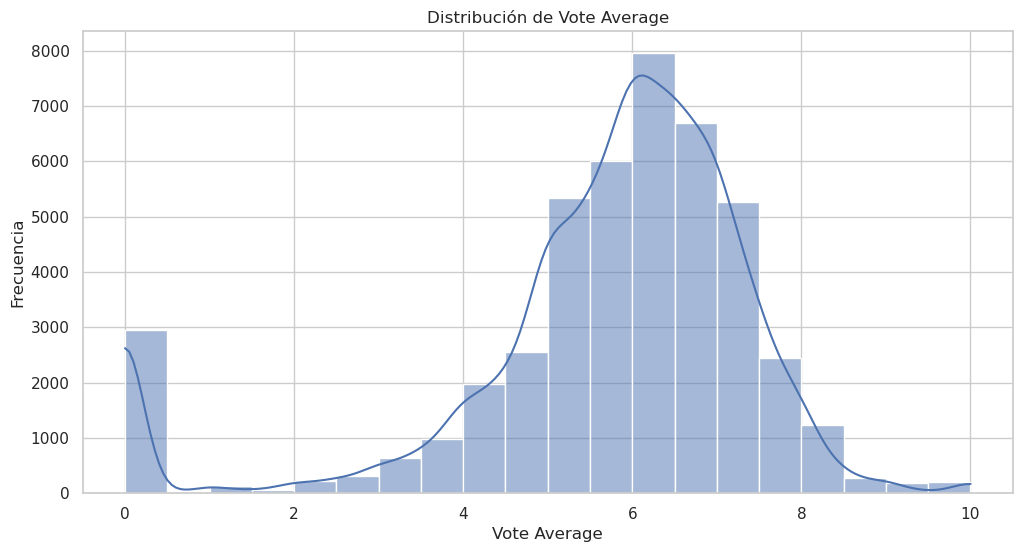

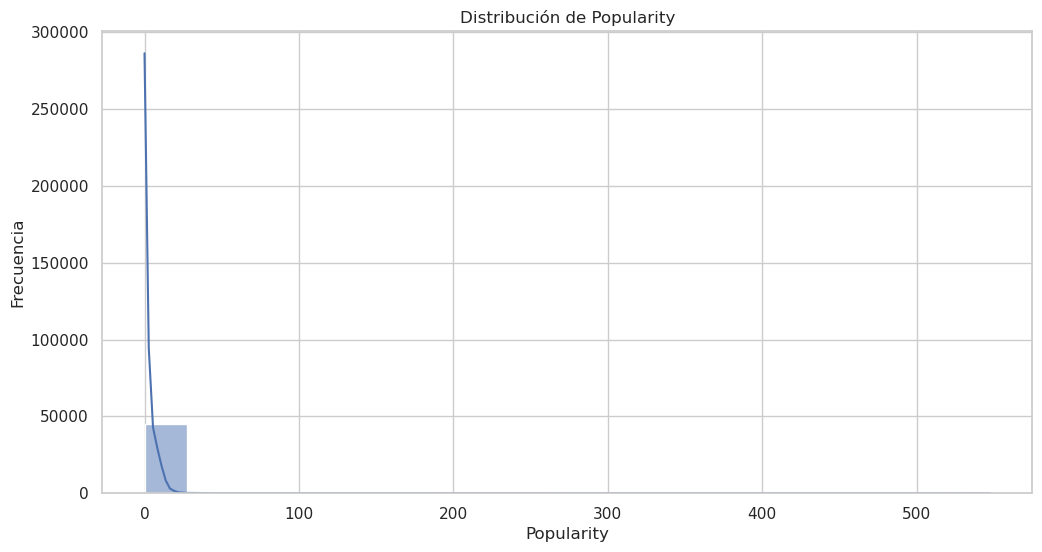

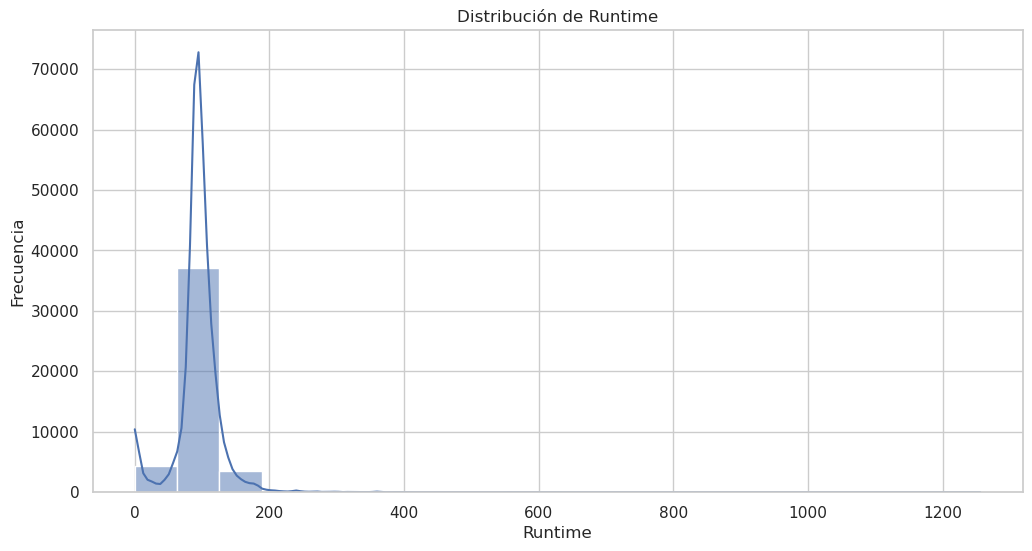

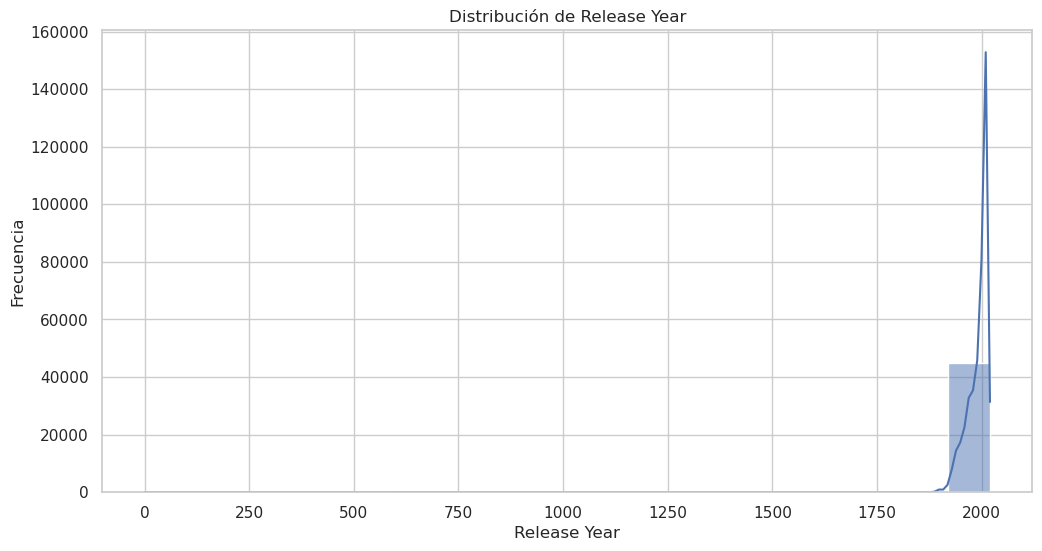

In [5]:
# 1. Distribución de las Variables

# Histograma de 'vote_average'
plt.figure(figsize=(12, 6))
sns.histplot(df['vote_average'].dropna(), bins=20, kde=True)
plt.title('Distribución de Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de 'popularity'
plt.figure(figsize=(12, 6))
sns.histplot(df['popularity'].dropna(), bins=20, kde=True)
plt.title('Distribución de Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de 'runtime'
plt.figure(figsize=(12, 6))
sns.histplot(df['runtime'].dropna(), bins=20, kde=True)
plt.title('Distribución de Runtime')
plt.xlabel('Runtime')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de 'release_year'
plt.figure(figsize=(12, 6))
sns.histplot(df['release_year'].dropna(), bins=20, kde=True)
plt.title('Distribución de Release Year')
plt.xlabel('Release Year')
plt.ylabel('Frecuencia')
plt.show()

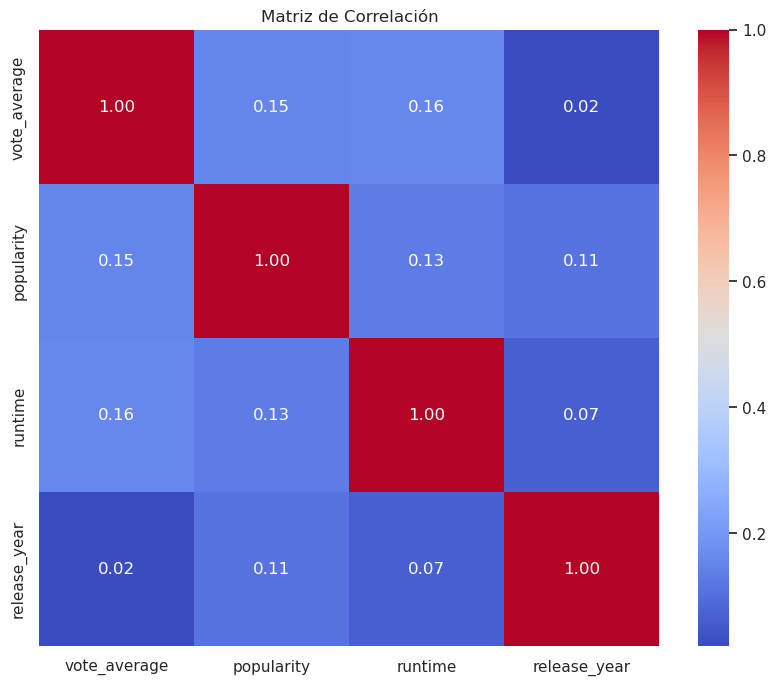

In [6]:
# 2. Análisis de Correlación

# Crear un DataFrame con solo las columnas numéricas de interés
features = df[['vote_average', 'popularity', 'runtime', 'release_year']]

# Calcular la matriz de correlación
corr_matrix = features.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

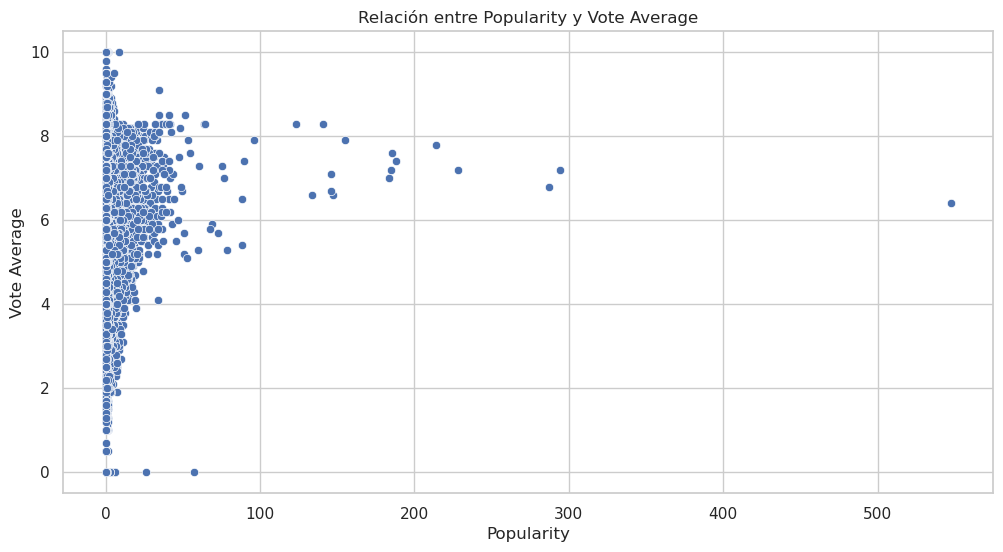

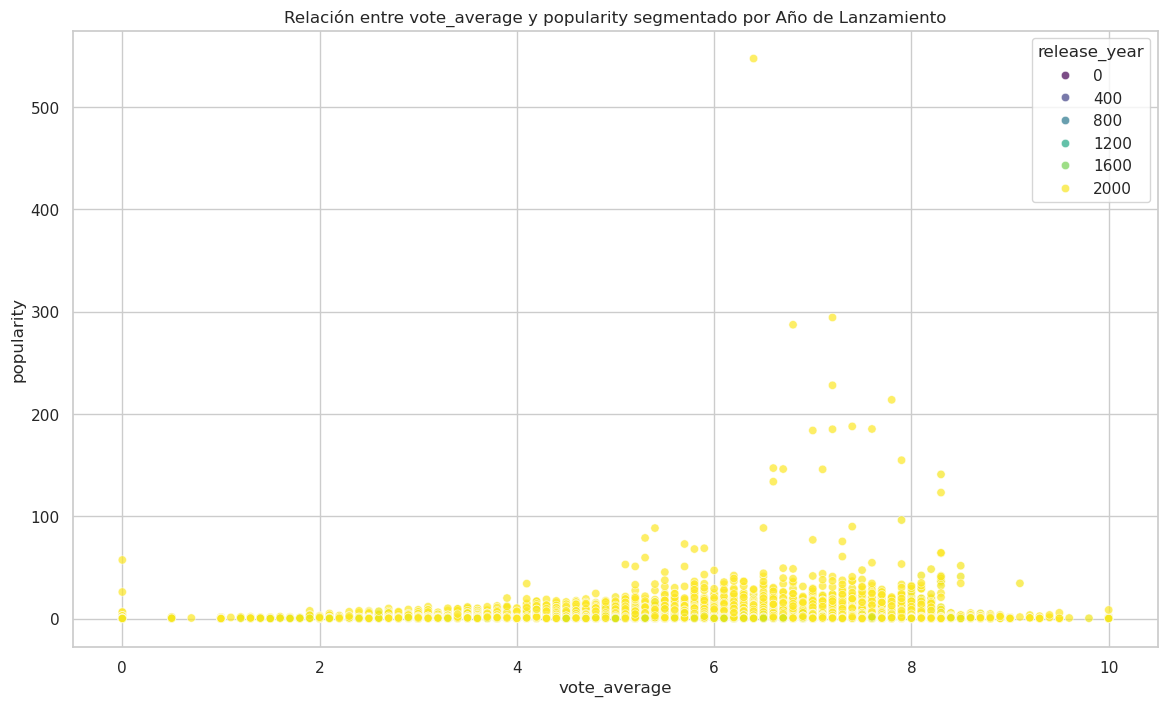

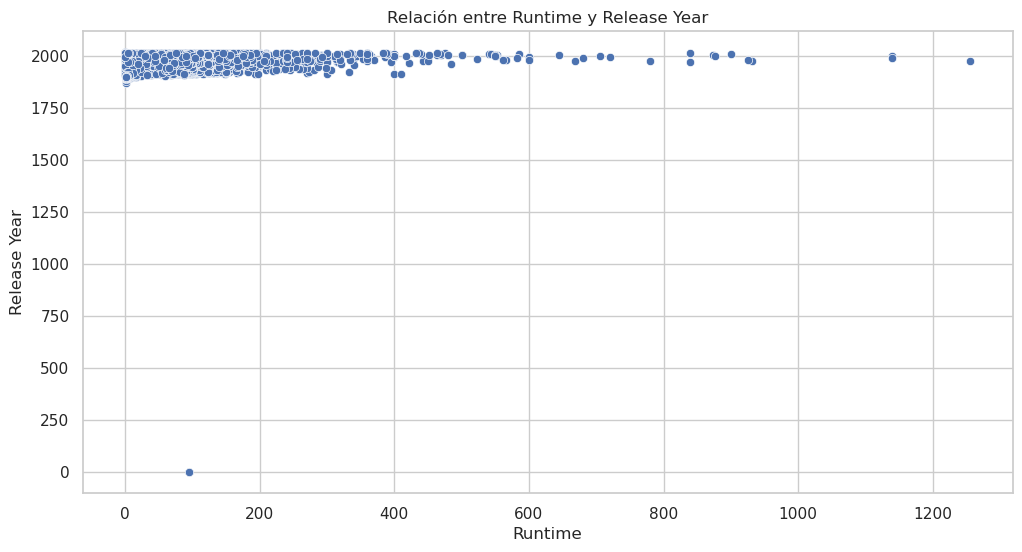

In [49]:
# 3. Relación entre Variables

# Gráfico de dispersión entre 'popularity' y 'vote_average'
plt.figure(figsize=(12, 6))
sns.scatterplot(x='popularity', y='vote_average', data=df)
plt.title('Relación entre Popularity y Vote Average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.show()

# Gráfico de dispersión entre 'vote_average' y 'popularity' segmentado por 'release_year'
plt.figure(figsize=(14, 8))
sns.scatterplot(x='vote_average', y='popularity', hue='release_year', data=df, palette='viridis', alpha=0.7)
plt.title('Relación entre vote_average y popularity segmentado por Año de Lanzamiento')
plt.show()

# Relación entre 'runtime' y 'release_year'
plt.figure(figsize=(12, 6))
sns.scatterplot(x='runtime', y='release_year', data=df)
plt.title('Relación entre Runtime y Release Year')
plt.xlabel('Runtime')
plt.ylabel('Release Year')
plt.show()

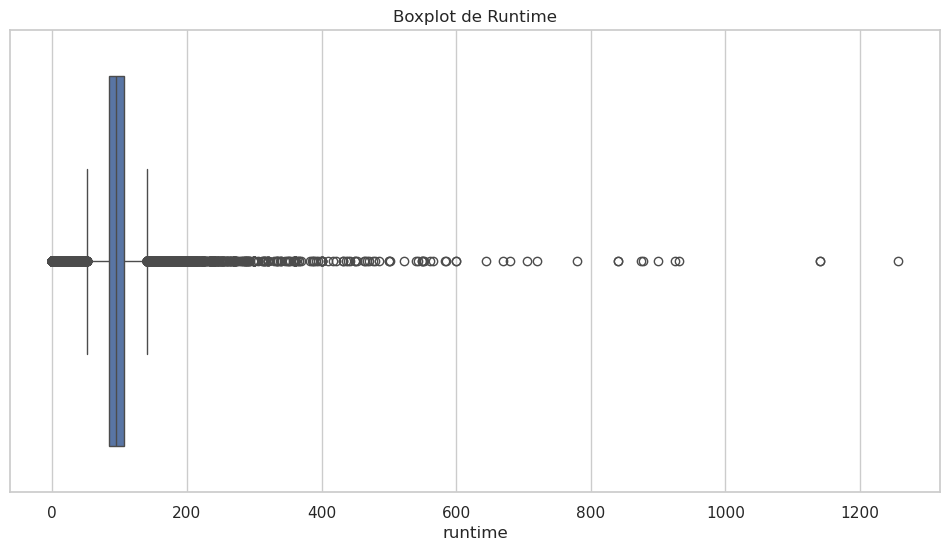

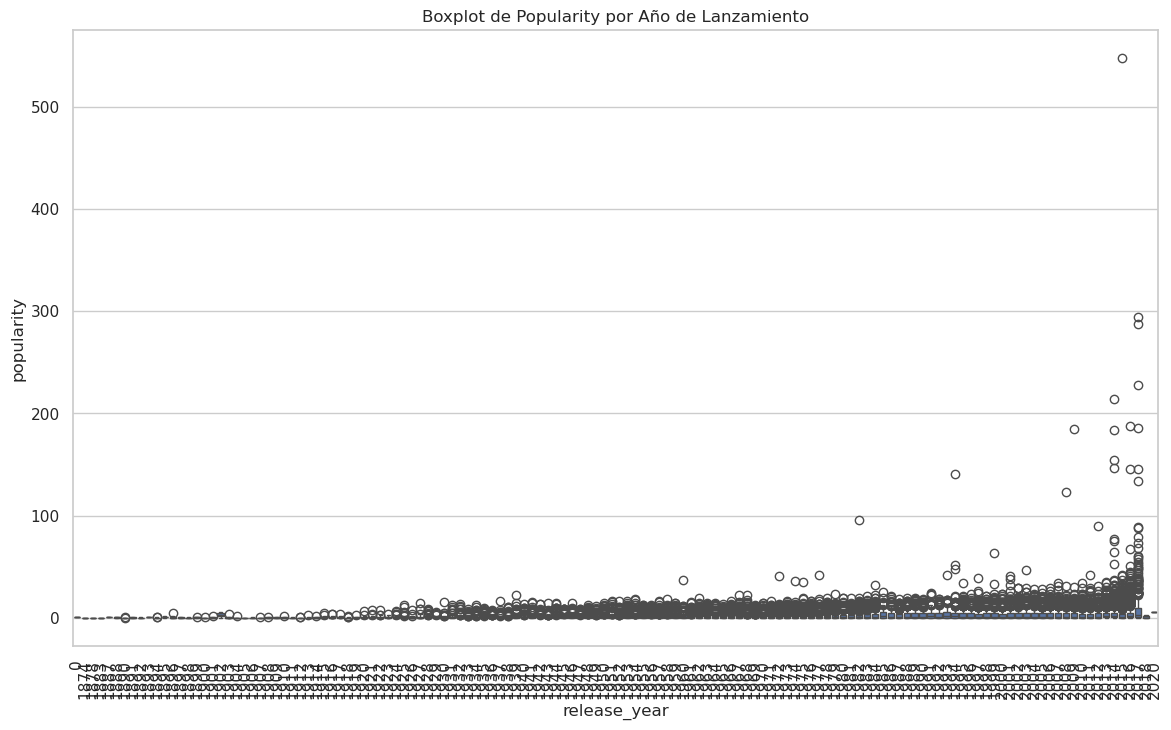

In [50]:
# 4. Boxplot para 'runtime' y 'popularity'

# Boxplot para 'runtime' para observar outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['runtime'])
plt.title('Boxplot de Runtime')
plt.show()

# Boxplot para 'popularity' segmentado por 'release_year'
plt.figure(figsize=(14, 8))
sns.boxplot(x='release_year', y='popularity', data=df)
plt.xticks(rotation=90)
plt.title('Boxplot de Popularity por Año de Lanzamiento')
plt.show()

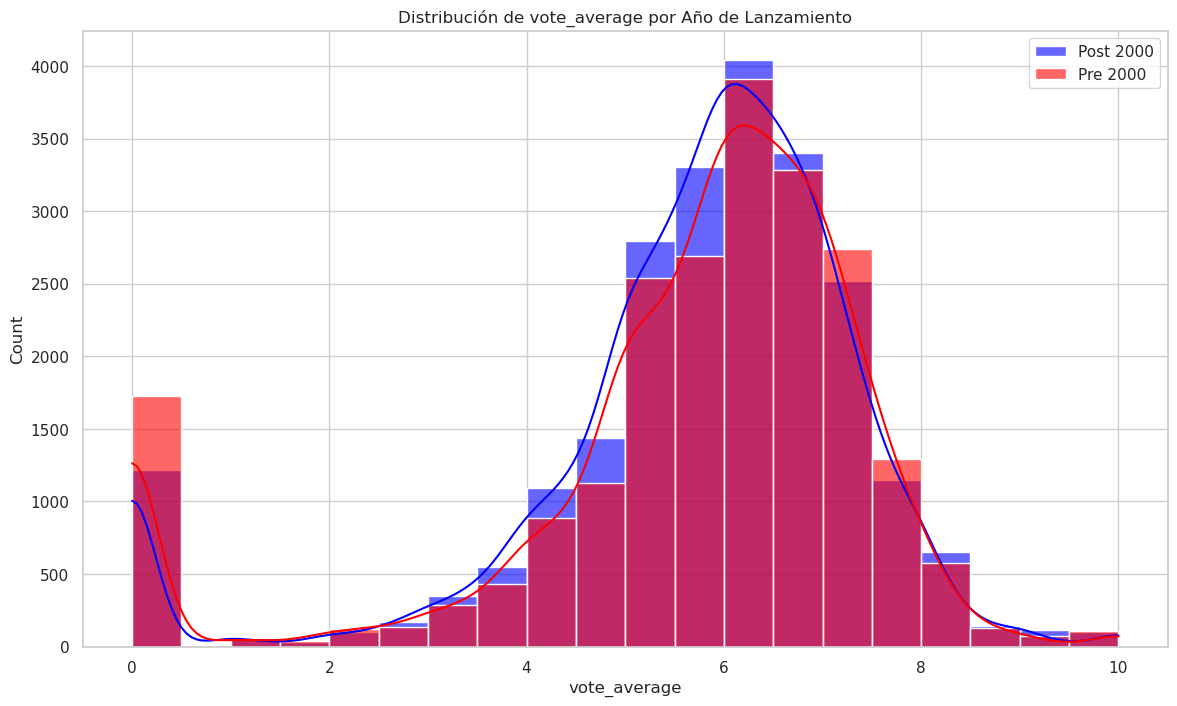

In [51]:
#5 Segmentación por año de lanzamiento
plt.figure(figsize=(14, 8))
sns.histplot(df[df['release_year'] > 2000]['vote_average'], bins=20, kde=True, label='Post 2000', color='blue', alpha=0.6)
sns.histplot(df[df['release_year'] <= 2000]['vote_average'], bins=20, kde=True, label='Pre 2000', color='red', alpha=0.6)
plt.title('Distribución de vote_average por Año de Lanzamiento')
plt.legend()
plt.show()

# Implementación de la métrica de similitud coseno:

In [8]:
def get_top_5_recommendations(df, base_movie_title):
    # Verificar si la película base está en el DataFrame
    if base_movie_title not in df['title'].values:
        raise ValueError(f"La película '{base_movie_title}' no se encuentra en el dataset.")
    
    # Paso 1: Preparar el Dataset
    features = ['vote_average', 'popularity', 'runtime', 'release_year']
    X = df[features]

    # Normalizar las características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Paso 2: Encontrar el índice de la película base
    movie_base_index = df[df['title'] == base_movie_title].index[0]
    movie_base_vector = X_scaled[movie_base_index].reshape(1, -1)

    # Paso 3: Calcular la Similitud del Coseno
    similarities = cosine_similarity(movie_base_vector, X_scaled).flatten()

    # Paso 4: Añadir la similitud al DataFrame
    df['similarity'] = similarities

    # Paso 5: Obtener las 5 películas más similares
    recommendations = (df[df['title'] != base_movie_title]
                       .sort_values(by='similarity', ascending=False)
                       .head(5))
    
    # Devolver la lista de títulos
    top_5_titles = recommendations['title'].tolist()
    return top_5_titles